# **Import Library**

In [ ]:
 # library untuk menangani data
 import zipfile
 import os
 import re
 import numpy as np
 import pandas as pd
 import tensorflow as tf
 import matplotlib.pyplot as plt
 import seaborn as sns
 import nltk
 …from sklearn.metrics import cohen_kappa_score
 from sklearn.metrics import mean_squared_error
 from tensorflow.keras.models import Sequential
 from tensorflow.keras.optimizers import Adam
 from tensorflow.keras.layers import Embedding, SpatialDropout1D, GlobalMaxPooling1D
 from tensorflow.keras.layers import Input, LSTM, BatchNormalization, Dropout, Dense, Lambda
 from sklearn.model_selection import train_test_split
 from

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Cek versi library
print("TensorFlow:", tf.__version__)

TensorFlow: 2.17.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load dataset

In [ ]:
# Path ke file zip di Google Drive
zip_path = '/content/drive/MyDrive/learning-agency-lab-automated-essay-scoring-2.zip'
extract_path = '/content/dataset'

# Mengekstrak file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Memastikan bahwa file telah diekstrak
extracted_files = os.listdir(extract_path)
print("Files in extracted folder:", extracted_files)

# Cek apakah file yang dibutuhkan ada sebelum memuatnya
train_file = os.path.join(extract_path, 'train.csv')
test_file = os.path.join(extract_path, 'test.csv')
sample_submission_file = os.path.join(extract_path, 'sample_submission.csv')

if all(os.path.exists(file) for file in [train_file, test_file, sample_submission_file]):
    # Membaca dataset yang diekstraksi
    train = pd.read_csv(train_file)
    test = pd.read_csv(test_file)
    sample_submission = pd.read_csv(sample_submission_file)


Files in extracted folder: ['train.csv', 'test.csv', 'sample_submission.csv']


# **Exploratory Data Analysis**

## Informasi Dataset

{test/train}.csv
* essay_id: Pengenal unik untuk setiap esai.
* full_text: Teks esai.
* score: Skor esai dengan rentang 1-6.

sample_submission.csv : Sampel valid yang dimasukkan untuk prediksi.  

In [ ]:
print('train data shape:', train.shape )
train.head()

train data shape: (17307, 3)


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [ ]:
train.describe()

,score
count,17307.000000
mean,2.948402
std,1.044899
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,6.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


In [ ]:
train.isnull().sum()

,0
essay_id,0
full_text,0
score,0


In [ ]:
print('test data shape:', test.shape )
test.head()

test data shape: (3, 2)


,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [ ]:
test.isnull().sum()

,0
essay_id,0
full_text,0


In [ ]:
sample_submission.head()

,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,4


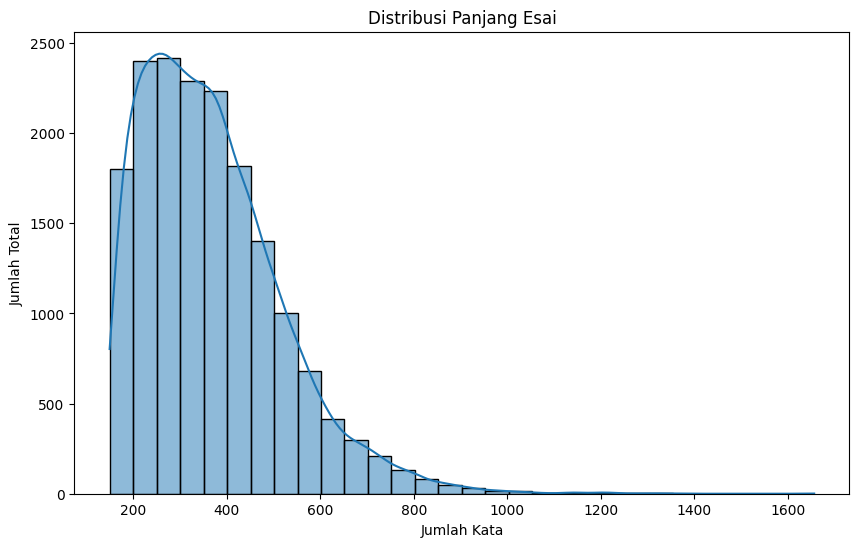

In [ ]:
# Menghitung panjang esai berdasarkan jumlah kata yang dipisahkan oleh spasi dalam setiap teks.
essay_lengths = train['full_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(essay_lengths, bins=30, kde=True)
plt.title('Distribusi Panjang Esai')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Total')
plt.show()

In [ ]:
# Hitung jumlah kata pada setiap esai
essay_lengths = train['full_text'].apply(lambda x: len(x.split()))

print(f"Minimum Panjang Esai: {essay_lengths.min()} kata")
print(f"Maximum Panjang Esai: {essay_lengths.max()} kata")
print(f"Rata-rata Panjang Esai: {essay_lengths.mean():.2f} kata")
print(f"Median Panjang Esai: {essay_lengths.median()} kata")
print(f"25th Persentil: {essay_lengths.quantile(0.25)} kata")
print(f"50th Persentil (Median): {essay_lengths.quantile(0.50)} kata")
print(f"75th Persentil: {essay_lengths.quantile(0.75)} kata")

Minimum Panjang Esai: 150 kata
Maximum Panjang Esai: 1656 kata
Rata-rata Panjang Esai: 368.35 kata
Median Panjang Esai: 345.0 kata
25th Persentil: 253.0 kata
50th Persentil (Median): 345.0 kata
75th Persentil: 452.0 kata


<ipython-input-14-17e5cb8ffaec>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='score', data=train, palette='viridis')


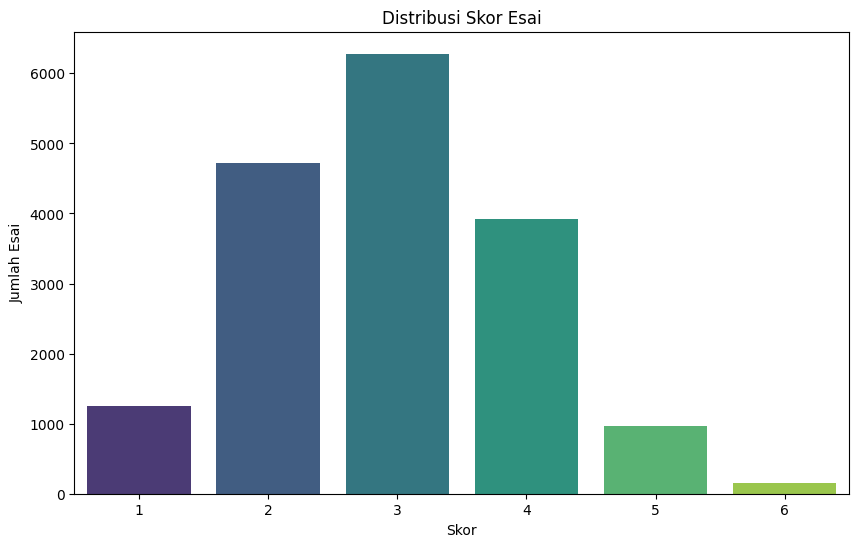

In [ ]:
# Distribusi skor esai
plt.figure(figsize=(10, 6))
sns.countplot(x='score', data=train, palette='viridis')
plt.title('Distribusi Skor Esai')
plt.xlabel('Skor')
plt.ylabel('Jumlah Esai')
plt.show()

In [ ]:
train['score'].value_counts()

,count
score,
3,6280
2,4723
4,3926
1,1252
5,970
6,156


In [ ]:
train['full_text'].head()

,full_text
0,Many people have car where they live. The thin...
1,I am a scientist at NASA that is discussing th...
2,People always wish they had the same technolog...
3,"We all heard about Venus, the planet without a..."
4,"Dear, State Senator\n\nThis is a letter to arg..."


# **Preprocessing Data**

In [ ]:
# Membersihkan teks
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

In [ ]:
# Implementasi pembersihan teks
train['clean_text'] = train['full_text'].apply(clean_text)
test['clean_text'] = test['full_text'].apply(clean_text)

In [ ]:
train['clean_text'].value_counts()

,count
clean_text,
many people have car where they live the thing they dont know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in vaubangermany they dont have that proble because 70 percent of vaubans families do not own carsand 57 percent sold a car to move there street parkig driveways and home garages are forbidden on the outskirts of freiburd that near the french and swiss borders you probaly wont see a car in vaubans streets because they are completely car free but if some that lives in vauban that owns a car ownership is allowedbut there are only two places that you can park a large garages at the edge of the developmentwhere a car owner buys a space but it not cheap to buy one they sell the space for you car for 40000 along with a home the vauban people completed this in 2006 they said that this an example of a growing trend in europethe untile states and some where else are suburban life from auto use this is called smart planning the current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in europe and up to 50 percent in some car intensive in the united states i honeslty think that good idea that they did that is vaudan because that makes cities denser and better for walking and in vauban there are 5500 residents within a rectangular square mile in the artical david gold berg said that all of our development since world war 2 has been centered on the carsand that will have to change and i think that was very true what david gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in vauban so people can see how we really dont need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car it good that they are doing that if you thik about your help the earth in way and thats a very good thing to in the united states the environmental protection agency is promoting what is called car reducedcommuntuntiesand the legislators are starting to actif cautiously maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year in previous bill80 percent of appropriations have by law gone to highways and only 20 percent to other transports there many good reason why they should do this,1
seagoing cowboys program in this essay im going to give you details of why you should sign up to become apart of the seagoing cowboys program the first reason is you will go on many adventures and trips reason two is you get to take care of animals like horses young cows and mules reason three is that youll become an seagoing cowboy you get to help countries and animals to help these countries recover their food supplies animals and more 44 nations will join together to form unrra the united nations relief and rehabliltation adminstration seagoing cowboys will take care of the horses young cows and mules that were shipped oversea it will make you more aware of people of the countries and their needs and that awareness will stay with you it will much of an adventure to you youll have fun on board especially on return trips after the animals had been unloaded youll get to play many games like baseball volleyball games in the empty holds where the animals had been housed tabletennis tournaments fencing boxing whittling and games also helped pass the time sometimes you will be served as night watchman that job means to check on the nails every hour i hope this essay really expired you in excellent many ways to be contined,1
the challenge of exploring venus says much about the challenge and how we might be able to study venus but

In [ ]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

# Tokenisasi teks menjadi kata-kata
train_tokens = [word_tokenize(text) for text in train['clean_text']]
test_tokens = [word_tokenize(text) for text in test['clean_text']]

In [ ]:
# Melatih model Word2Vec
model_w2v = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# Menyimpan model untuk penggunaan di masa mendatang
model_w2v.save("word2vec_model")

In [ ]:
# Fungsi untuk mendapatkan vektor rata-rata kata
def get_average_word2vec(tokens_list, model, vector_size):
    vec = np.zeros(vector_size)
    valid_words = 0
    for word in tokens_list:
        if word in model.wv:
            vec += model.wv[word]
            valid_words += 1
    if valid_words > 0:
        vec /= valid_words
    return vec

In [ ]:
# Menyusun fitur teks dengan vektor rata-rata Word2Vec
X_train_w2v = np.array([get_average_word2vec(tokens, model_w2v, 100) for tokens in train_tokens])
X_test_w2v = np.array([get_average_word2vec(tokens, model_w2v, 100) for tokens in test_tokens])

In [ ]:
# Target variable: the score (1-6)
y_train = train['score'].values



# **Modelling Data**

In [ ]:
# Membagi data X_train_w2v dan y_train menjadi train dan validation set dengan stratifikasi berdasarkan 'score'
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_w2v, y_train, test_size=0.2, stratify=y_train, random_state=42)


In [ ]:
# Mengubah input menjadi 3D untuk LSTM: (batch_size, 1, features)
X_train_final_lstm = np.expand_dims(X_train_final, axis=1)  # Menambahkan dimensi waktu (timesteps)
X_val_lstm = np.expand_dims(X_val, axis=1)

# Membangun model LSTM
model_lstm = Sequential([
    Input(shape=(1, X_train_final.shape[1])),  # Menggunakan Input layer
    LSTM(128, return_sequences=True, kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),  # Aktivasi sigmoid untuk output [0, 1]
    Lambda(lambda x: x * 5 + 1)  # Skala output ke rentang [1, 6]
])

# Kompilasi model
optimizer = Adam(learning_rate=0.0005)
model_lstm.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

# Menampilkan ringkasan model
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 128)              │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169,537 (662.25 KB)

 Trainable params: 169,153 (660.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# Callback untuk menyimpan bobot model terbaik
checkpoint_cb = ModelCheckpoint(
    filepath="best_model_lstm.weights.h5",
    save_best_only=True,
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# Callback untuk early stopping dan pengurangan learning rate
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
]

# Melatih model
history_lstm = model_lstm.fit(
    X_train_final_lstm, y_train_final,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_lstm, y_val),
    callbacks=callbacks,
    verbose=1
)

# Evaluasi model pada data validasi
y_val_pred = model_lstm.predict(X_val_lstm)
y_val_pred = y_val_pred.round().astype(int)  # Pembulatan hasil prediksi

# Cohen's Kappa untuk evaluasi
kappa_score = cohen_kappa_score(y_val, y_val_pred, weights='quadratic')
print("Cohen's Kappa Score (Validation):", kappa_score)

Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 3.7659 - mae: 1.1058 - val_loss: 2.4300 - val_mae: 0.9981 - learning_rate: 5.0000e-04
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.1756 - mae: 0.9138 - val_loss: 1.8086 - val_mae: 0.9244 - learning_rate: 5.0000e-04
Epoch 3/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.6531 - mae: 0.8493 - val_loss: 1.3854 - val_mae: 0.7802 - learning_rate: 5.0000e-04
Epoch 4/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.3479 - mae: 0.7904 - val_loss: 1.1734 - val_mae: 0.7391 - learning_rate: 5.0000e-04
Epoch 5/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1.1673 - mae: 0.7648 - val_loss: 1.0392 - val_mae: 0.7191 - learning_rate: 5.0000e-04
Epoch 6/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.0517 - mae: 0.7538 - val_loss: 0.9368 - val_mae: 0.6980 - learning_rate: 5.0000e-04
Epoch 7/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9584 - mae: 0.7355 - val_loss: 0.8735 - val_mae: 0

In [ ]:
X_test_lstm = np.expand_dims(X_test_w2v, axis=1)
y_test_pred = model_lstm.predict(X_test_lstm)
y_test_pred = y_test_pred.round().astype(int)

# Simpan hasil prediksi ke dalam dataframe
test['predicted_score'] = y_test_pred
print(test[['essay_id', 'predicted_score']].head())

# Find the epoch with the best validation MAE
best_epoch = np.argmin(history_lstm.history['val_mae'])  # val_mae is used for validation mean absolute error
best_loss = history_lstm.history['val_loss'][best_epoch]
best_mae = history_lstm.history['val_mae'][best_epoch]

# Print and display best results
print(f'\n{"=" * 17} RESULTS {"=" * 17}')
print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST MAE   : {best_mae:.3f}\n>>>> BEST Epoch : {best_epoch}')
print('=' * 50)
# # Mengubah data uji menjadi 3D untuk kompatibilitas dengan model LSTM
# X_test_lstm = np.expand_dims(X_test_w2v, axis=1)

# # Evaluasi model pada data uji
# test_loss, test_mae = model_lstm.evaluate(X_test_lstm, test['score'].values, verbose=1)
# print(f'Test Loss (MAE): {test_loss:.4f}')
# print(f'Test Mean Absolute Error (MAE): {test_mae:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
  essay_id  predicted_score
0  000d118                2
1  000fe60                3
2  001ab80                4

================= RESULTS =================
>>>> BEST Loss  : 0.675
>>>> BEST MAE   : 0.659
>>>> BEST Epoch : 68


In [ ]:
# Make predictions using the trained model on validation data
X_val_lstm = np.expand_dims(X_val, axis=1)  # Pastikan data validasi memiliki dimensi yang sesuai
valid_preds = model_lstm.predict(X_val_lstm, verbose=0)

# Format predictions and true answers
pred_scores = valid_preds.round().astype(int).clip(1, 6)  # Pembulatan ke skor valid (1-6)
true_scores = y_val

# Check 5 Predictions
print("# Predictions\n")
for i in range(10):
    text = train['full_text'].iloc[i]
    pred_answer = pred_scores[i][0]  # Akses nilai prediksi
    true_answer = true_scores[i]  # Nilai aktual
    print(f" Text {i+1}:\n{text[:150]} .... {text[-150:]}\n")
    print(f" True: {true_answer}\n")
    print(f" Predicted: {pred_answer}\n")
    print("-" * 90, "\n")


# Predictions

 Text 1:
Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the .... 80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this.    

 True: 3

 Predicted: 3

------------------------------------------------------------------------------------------ 

 Text 2:
I am a scientist at NASA that is discussing the "face" on mars. I will be explaining how the "face" is a land form. By sharing my information about th .... it's a martian sculpture. Which every one that works at NASA says it's a landform and they are all the ones working on the planet and taking pictures.

 True: 3

 Predicted: 3

------------------------------------------------------------------------------------------ 

 Text 3:
People always wish they had the same technology that they have seen in movies, or the best new piece of te

In [ ]:
# Menyimpan model dalam format .h5
model_lstm.save('model_lstm.h5')

Model telah disimpan dalam format .h5
